In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [132]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [142]:
hidden_size = 200
embed_size = 3

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, embed_size), generator=g)
W1 = torch.randn((block_size * embed_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [143]:
for p in parameters:
  p.requires_grad = True

In [144]:
lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre

In [145]:
lri = []
lossi = []
stepi = []

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * embed_size) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print (loss.item())

2.1900837421417236


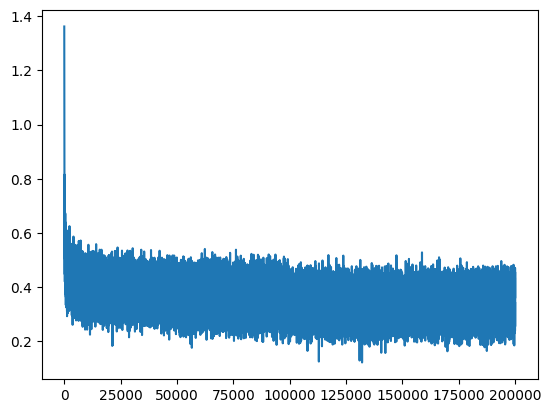

In [146]:
plt.plot(stepi, lossi)

In [147]:

# forward pass
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, block_size * embed_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())


2.226045608520508


In [148]:
# forward pass
emb = C[Xte] # (32, 3, 10)
h = torch.tanh(emb.view(-1, block_size * embed_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.2226545810699463


(27, 3)
(27, 2)


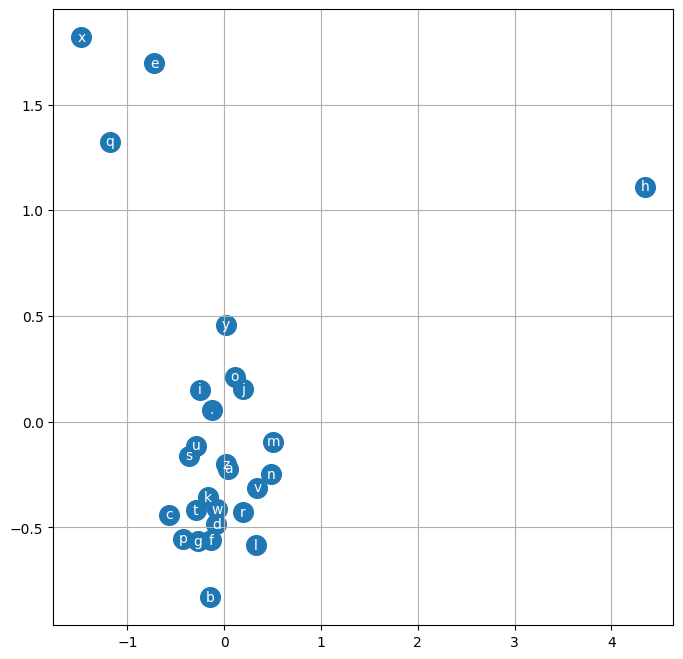

In [149]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components (2 dimensions)
pca = PCA(n_components=2)

# Detach the tensor and convert it to a NumPy array
detached_C = C.detach().numpy()

print (detached_C.shape)

# Fit PCA to your data
pca.fit(detached_C)

# Transform your data to 2 dimensions
transformed_C = pca.transform(detached_C)

print (transformed_C.shape)

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(transformed_C[:,0].data, transformed_C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(transformed_C[i,0].item(), transformed_C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [150]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range (10):
    out = []
    context = [0] * block_size # initialize with all ...

    while (True):
        emb = C[torch.tensor([context])] # (32, 3, 10)
        h = torch.tanh(emb.view(-1, block_size * embed_size) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2 # (32, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print (''.join(itos[i] for i in out))

mora.
kayah.
see.
med.
rylle.
emma.
jendrari.
adee.
doeli.
jemi.
